In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
%matplotlib inline
#plt.rcParams.update({'font.size': 32})
%config Completer.use_jedi = False

#import tensorflow.config.experimental
#from tensorflow.config.experimental import list_physical_devices, set_memory_growth
physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def print_params(model):
    total_params = 0 # initialize counter for total params
    trainable_params = 0 # initialize counter for trainable params
    print('Layer Name\t\tType\t\tFilter shape\t\t# Parameters\tTrainable') # print column headings
    for layer in model.layers: # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='MaxPooling2D': # print for max pool layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t---------------\t\t---')
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t---------------\t\t---')
        elif ltype=='Dense': # print for dense layers
            weights = layer.get_weights()
            print(lname+'\t\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='Dropout': # print for dropout layers
            print(lname+'\t\t'+ltype+'\t\t------------------\t---')
    print('---------------')
    print('Total trainable parameters: '+str(trainable_params)) # print total params
    print('Total untrainable parameters: '+str(total_params-trainable_params))
    print('Total parameters: '+str(total_params))

In [3]:
def print_shapes(model):
    print('Layer Name\t\tType\t\tInput Shape\t\tOutput Shape\tTrainable')# print column headings
    for layer in model.layers:  # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape)+'\t'+str(layer.trainable))
        elif ltype=='MaxPooling2D': # print for maxpool layers
            print(lname+'\t\t'+ltype+'\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))
        elif ltype=='Dense': # print for dense layers
            print(lname+'\t\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t\t'+\
                  str(layer.output_shape)+'\t'+str(layer.trainable))
        elif ltype=='Dropout': # print for dropout layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))

In [4]:
from keras.applications.vgg16 import preprocess_input
from astropy.io import fits
import skimage.transform

In [5]:
import keras
from keras.layers import Input
import keras.applications
input_tensor = Input(shape=(224,224,3))

In [6]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D

In [7]:
# def fire_module(x,s1,e1,e3):
#     s1x = Conv2D(s1,kernel_size = 1, padding = 'same')(x)
#     s1x = ReLU()(s1x)
#     e1x = Conv2D(e1,kernel_size = 1, padding = 'same')(s1x)
#     e3x = Conv2D(e3,kernel_size = 3, padding = 'same')(s1x)
#     x = concatenate([e1x,e3x])
#     x = ReLU()(x)
#     return x

In [8]:
# import h5py
# from keras.models import Model
# from keras.layers import Input, Activation, Concatenate
# from keras.layers import Flatten, Dropout
# from keras.layers import Convolution2D, MaxPooling2D
# from keras.layers import GlobalAveragePooling2D

# def SqueezeNet(nb_classes, inputs=(3, 222, 222)):
#     """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
#     @param nb_classes: total number of final categories
#     Arguments:
#     inputs -- shape of the input images (channel, cols, rows)
#     """

#     input_img = Input(shape=inputs)
#     conv1 = Convolution2D(
#         96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
#         strides=(2, 2), padding='same', name='conv1',
#         data_format="channels_first")(input_img)
#     maxpool1 = MaxPooling2D(
#         pool_size=(3, 3), strides=(2, 2), name='maxpool1',
#         data_format="channels_first")(conv1)
#     fire2_squeeze = Convolution2D(
#         16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire2_squeeze',
#         data_format="channels_first")(maxpool1)
#     fire2_expand1 = Convolution2D(
#         64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire2_expand1',
#         data_format="channels_first")(fire2_squeeze)
#     fire2_expand2 = Convolution2D(
#         64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire2_expand2',
#         data_format="channels_first")(fire2_squeeze)
#     merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

#     fire3_squeeze = Convolution2D(
#         16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire3_squeeze',
#         data_format="channels_first")(merge2)
#     fire3_expand1 = Convolution2D(
#         64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire3_expand1',
#         data_format="channels_first")(fire3_squeeze)
#     fire3_expand2 = Convolution2D(
#         64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire3_expand2',
#         data_format="channels_first")(fire3_squeeze)
#     merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

#     fire4_squeeze = Convolution2D(
#         32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire4_squeeze',
#         data_format="channels_first")(merge3)
#     fire4_expand1 = Convolution2D(
#         128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire4_expand1',
#         data_format="channels_first")(fire4_squeeze)
#     fire4_expand2 = Convolution2D(
#         128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire4_expand2',
#         data_format="channels_first")(fire4_squeeze)
#     merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
#     maxpool4 = MaxPooling2D(
#         pool_size=(3, 3), strides=(2, 2), name='maxpool4',
#         data_format="channels_first")(merge4)

#     fire5_squeeze = Convolution2D(
#         32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire5_squeeze',
#         data_format="channels_first")(maxpool4)
#     fire5_expand1 = Convolution2D(
#         128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire5_expand1',
#         data_format="channels_first")(fire5_squeeze)
#     fire5_expand2 = Convolution2D(
#         128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire5_expand2',
#         data_format="channels_first")(fire5_squeeze)
#     merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

#     fire6_squeeze = Convolution2D(
#         48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire6_squeeze',
#         data_format="channels_first")(merge5)
#     fire6_expand1 = Convolution2D(
#         192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire6_expand1',
#         data_format="channels_first")(fire6_squeeze)
#     fire6_expand2 = Convolution2D(
#         192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire6_expand2',
#         data_format="channels_first")(fire6_squeeze)
#     merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

#     fire7_squeeze = Convolution2D(
#         48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire7_squeeze',
#         data_format="channels_first")(merge6)
#     fire7_expand1 = Convolution2D(
#         192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire7_expand1',
#         data_format="channels_first")(fire7_squeeze)
#     fire7_expand2 = Convolution2D(
#         192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire7_expand2',
#         data_format="channels_first")(fire7_squeeze)
#     merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

#     fire8_squeeze = Convolution2D(
#         64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire8_squeeze',
#         data_format="channels_first")(merge7)
#     fire8_expand1 = Convolution2D(
#         256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire8_expand1',
#         data_format="channels_first")(fire8_squeeze)
#     fire8_expand2 = Convolution2D(
#         256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire8_expand2',
#         data_format="channels_first")(fire8_squeeze)
#     merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

#     maxpool8 = MaxPooling2D(
#         pool_size=(3, 3), strides=(2, 2), name='maxpool8',
#         data_format="channels_first")(merge8)
#     fire9_squeeze = Convolution2D(
#         64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire9_squeeze',
#         data_format="channels_first")(maxpool8)
#     fire9_expand1 = Convolution2D(
#         256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire9_expand1',
#         data_format="channels_first")(fire9_squeeze)
#     fire9_expand2 = Convolution2D(
#         256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
#         padding='same', name='fire9_expand2',
#         data_format="channels_first")(fire9_squeeze)
#     merge9 = Concatenate(axis=1)([fire9_expand1, fire9_expand2])

#     fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
#     conv10 = Convolution2D(
#         nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
#         padding='valid', name='conv10',
#         data_format="channels_first")(fire9_dropout)

#     global_avgpool10 = GlobalAveragePooling2D(data_format='channels_first')(conv10)
#     softmax = Activation("softmax", name='softmax')(global_avgpool10)

#     return Model(inputs=input_img, outputs=softmax)

In [9]:
train_df = pd.read_csv('train_data.csv',dtype=str)
val_df = pd.read_csv('val_data.csv',dtype=str)
test_df = pd.read_csv('test_data.csv',dtype=str)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
                                                    directory='',\
                                                    xcol='filename',y_col='class',\
                                                    target_size=(224,224), color_mode='rgb',\
                                                    batch_size=128, class_mode='categorical',\
                                                    shuffle=True) #RETURN TO TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(224,224), color_mode='rgb',\
                                                batch_size=128, class_mode='categorical',\
                                                shuffle=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(224,224), color_mode='rgb',\
                                                batch_size=128, class_mode='categorical',\
                                                shuffle=False)

Found 3741 validated image filenames belonging to 5 classes.
Found 1068 validated image filenames belonging to 5 classes.
Found 533 validated image filenames belonging to 5 classes.


In [11]:
# import tensorflowcv
# from tensorflowcv.model_provider import get_model
# from tensorflowcv.models.common import is_channels_first

# from tensorflowcv.model_provider import get_model as tfcv_get_model
# from tensorflowcv.model_provider import init_variables_from_state_dict as tfcv_init_variables_from_state_dict
# from tensorflowcv.models.common import is_channels_first
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 

# # model = tensorflowcv.model_provider.get_model("SqueezeNet", use_pretrained=True)

# model = tfcv_get_model("squeezenet_v1_1", pretrained=True, data_format="channels_first")
# x_shape = (3, 224, 224, None)
# x = tf.placeholder(dtype=tensorflow.float32, shape=x_shape, name='xx')
# y_net = model(x)



# from tensorflowcv.model_provider import get_model as tfcv_get_model
# from tensorflowcv.model_provider import init_variables_from_state_dict as tfcv_init_variables_from_state_dict
# import tf2cv
# import tensorflow as tf
# import numpy as np
# # import tensorflow.compat.v1 as tf
# # tf.disable_v2_behavior() 

# # net = tfcv_get_model("squeezenet_v1_1", pretrained=True, data_format="channels_first")
# # x = tf.placeholder(dtype=tf.float32, shape=(None, 3, 224, 224), name="xx")
# # y_net = net(x)

# # with tf.Session() as sess:
# #     tfcv_init_variables_from_state_dict(sess=sess, state_dict=net.state_dict)
# #     x_value = np.zeros((1, 3, 224, 224), np.float32)
# #     y = sess.run(y_net, feed_dict={x: x_value})

# from tf2cv.model_provider import get_model as tf2cv_get_model
# import tensorflow as tf

# model = tf2cv_get_model("squeezenet_v1_1", pretrained=True, data_format="channels_last")
# x = tf.random.normal((1, 224, 224, 3))
# y_net = net(x)

In [12]:
from keras.models import Model
from keras.layers import Add, Activation, Concatenate, Conv2D, Dropout 
from keras.layers import Flatten, Input, GlobalAveragePooling2D, MaxPooling2D
import keras.backend as K

__version__ = '0.0.1'


def SqueezeNet(input_shape, nb_classes, use_bypass=False, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.0
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        use_bypass   : if true, bypass connections will be created at fire module 3, 5, 7, and 9 (default: False)
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps (default: 1.0)
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(96*compression), (7,7), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3', use_bypass=use_bypass)
    x = create_fire_module(x, int(32*compression), name='fire4')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool4')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire5', use_bypass=use_bypass)
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7', use_bypass=use_bypass)
    x = create_fire_module(x, int(64*compression), name='fire8')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool8')(x)
    
    x = create_fire_module(x, int(64*compression), name='fire9', use_bypass=use_bypass)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
        
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def SqueezeNet_11(input_shape, nb_classes, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.1
    
    2.4x less computation over SqueezeNet 1.0 implemented above.
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(64*compression), (3,3), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool3')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire4')
    x = create_fire_module(x, int(32*compression), name='fire5')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool5')(x)
    
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7')
    x = create_fire_module(x, int(64*compression), name='fire8')
    x = create_fire_module(x, int(64*compression), name='fire9')

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    # Creating last conv10
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def output(x, nb_classes):
    x = Conv2D(nb_classes, (1,1), strides=(1,1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D(name='avgpool10')(x)
    x = Activation("softmax", name='softmax')(x)
    return x


def create_fire_module(x, nb_squeeze_filter, name, use_bypass=False):
    """
    Creates a fire module
    
    Arguments:
        x                 : input
        nb_squeeze_filter : number of filters of squeeze. The filtersize of expand is 4 times of squeeze
        use_bypass        : if True then a bypass will be added
        name              : name of module e.g. fire123
    
    Returns:
        x                 : returns a fire module
    """
    
    nb_expand_filter = 4 * nb_squeeze_filter
    squeeze    = Conv2D(nb_squeeze_filter,(1,1), activation='relu', padding='same', name='%s_squeeze'%name)(x)
    expand_1x1 = Conv2D(nb_expand_filter, (1,1), activation='relu', padding='same', name='%s_expand_1x1'%name)(squeeze)
    expand_3x3 = Conv2D(nb_expand_filter, (3,3), activation='relu', padding='same', name='%s_expand_3x3'%name)(squeeze)
    
    axis = get_axis()
    x_ret = Concatenate(axis=axis, name='%s_concatenate'%name)([expand_1x1, expand_3x3])
    
    if use_bypass:
        x_ret = Add(name='%s_concatenate_bypass'%name)([x_ret, x])
        
    return x_ret


def get_axis():
    axis = -1 if K.image_data_format() == 'channels_last' else 1
    return axis

In [13]:
nb_classes = 5
input_shape=(224, 224, 3)
model = SqueezeNet(input_shape, nb_classes, use_bypass=True, dropout_rate=0.5, compression=1.0) #drop out of 0.6 is the best so far (28%)
# model = SqueezeNet(nb_classes, inputs=(3, 224, 224))

In [14]:
# model.build((1, 224, 224, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 96  14208       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 55, 55, 96)   0           ['conv1[0][0]']                  
                                                                                              

In [15]:
def categorical_tnr(y_true,y_pred):
    import keras.backend as K
    y_true = K.argmax(y_true)
    y_pred = K.argmax(y_pred)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.cast(K.sum(neg_y_true * y_pred),'float32')
    tn = K.cast(K.sum(neg_y_true * neg_y_pred),'float32')
    tnr = tn / (tn + fp + K.epsilon())
    return tnr

def categorical_tpr(y_true,y_pred):
    import keras.backend as K
    y_true = K.argmax(y_true)
    y_pred = K.argmax(y_pred)
    neg_y_pred = 1 - y_pred
    fn = K.cast(K.sum(y_true * neg_y_pred),'float32')
    tp = K.cast(K.sum(y_true * y_pred),'float32')
    tpr = tp / (tp + fn + K.epsilon())
    return tpr

def categorical_tss(y_true,y_pred):
    import keras.backend as K
    tpr = categorical_tpr(y_true,y_pred)
    tnr = categorical_tnr(y_true,y_pred)
    tss = tpr + tnr - 1
    return tss

def save_con_mat(y_true, y_pred):
    import tensorflow as tf
    print((y_true.shape))
    print((y_pred.shape))
    con_matrix = tf.math.confusion_matrix(y_true, y_pred)
    # acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
    return con_matrix


In [16]:
from tensorflow.keras.optimizers import Adam
adam_opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
               metrics=['categorical_accuracy'])# save_con_mat]) #,categorical_tnr,categorical_tpr,categorical_tss])

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

filepath = 'BCS_CNN\\BCS_CNN.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_tss', verbose=1, save_best_only=False, mode='max')
early_stop = EarlyStopping(monitor='val_categorical_tss', min_delta=0.001, patience=5, verbose=1, mode='max')
#callbacks_list = [checkpoint, early_stop]
callbacks_list = [checkpoint]

step_size_train = np.ceil(train_generator.n/train_generator.batch_size)
print(step_size_train)
print('Batch size: ', train_generator.batch_size)
#step_size_train = 2373 # to help debug val accuracy issue
step_size_val = np.ceil(val_generator.n/val_generator.batch_size)
print(step_size_val)
#step_size_val = 303 # to help debug val accuracy issue

# the following assumes that 0 is the majority class
# class_weights = {0: 1.,
#                  1: (np.asarray(train_generator.classes)==0).sum()/(np.asarray(train_generator.classes)==1).sum()}
# the following taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#class_weights = {0: (1/(train_generator.classes==0).sum())*len(train_generator.classes)/2,
#                 1: (1/(train_generator.classes==1).sum())*len(train_generator.classes)/2}
# class_weights = {0: 1.,
#                 1: 6.}

from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
class_weights = dict(enumerate(class_weights))
print(class_weights)

30.0
Batch size:  128
9.0
{0: 1.425142857142857, 1: 1.4388461538461539, 2: 0.4241496598639456, 3: 0.9091130012150668, 4: 6.864220183486238}


In [23]:
history = model.fit(train_generator, steps_per_epoch=step_size_train, epochs=30, verbose=1,\
                     callbacks=callbacks_list, validation_data=val_generator, validation_steps=step_size_val,\
                     validation_freq=1, class_weight=class_weights)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 0.5782 - categorical_accuracy: 0.6808
Epoch 00001: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 8s 270ms/step - loss: 0.5782 - categorical_accuracy: 0.6808 - val_loss: 0.7426 - val_categorical_accuracy: 0.6994
Epoch 2/10


C:\Users\zacha\anaconda3\envs\ML_env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - ETA: 0s - loss: 0.4316 - categorical_accuracy: 0.7621
Epoch 00002: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 8s 269ms/step - loss: 0.4316 - categorical_accuracy: 0.7621 - val_loss: 0.6142 - val_categorical_accuracy: 0.7360
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.3594 - categorical_accuracy: 0.7904
Epoch 00003: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 8s 267ms/step - loss: 0.3594 - categorical_accuracy: 0.7904 - val_loss: 0.6117 - val_categorical_accuracy: 0.7509
Epoch 4/10
30/30 [==============================] - ETA: 0s - loss: 0.3180 - categorical_accuracy: 0.8238
Epoch 00004: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 8s 268ms/step - loss: 0.3180 - categorical_accuracy: 0.8238 - val_loss: 0.5545 - val_categorical_accuracy: 0.7968
Epoch 5/10
30/30 [==============================] - ETA: 0s - loss: 0.3096 - c

In [19]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

[2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 4 2
 4 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 4 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 4 3 3 4 4 3 6 3 3 4 4 3 4 2 3 4 5 4 4 3 2 2 4 3 3 3 4 3 3 3 3 4 4 3 4
 3 4 4 3 4 4 3 4 3 4 3 3 3 3 3 4 3 3 3 3 3 3 3 4 6 6 3 5 3 4 5 6 4 4 3 4 4
 4 4 6 4 4 4 5 4 2 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 5 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

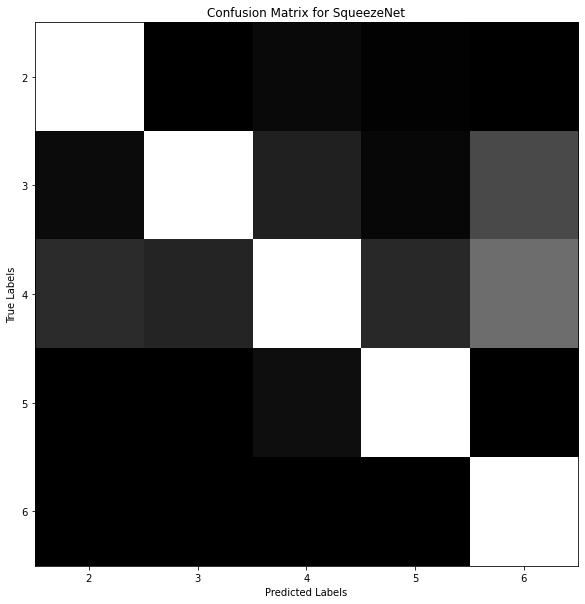

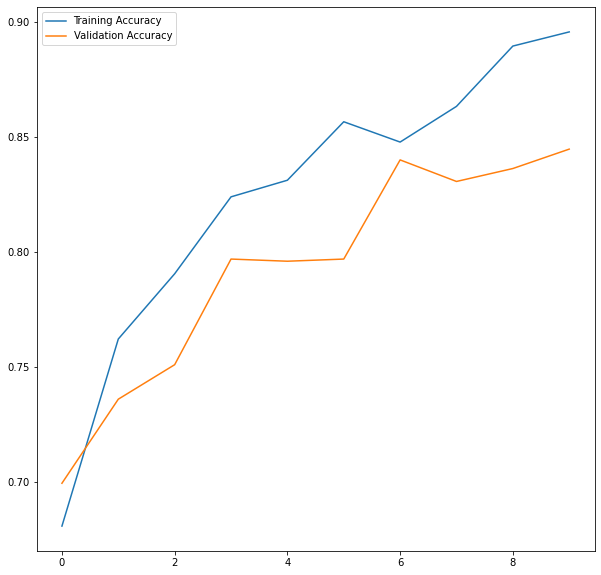

In [25]:
import sklearn.metrics

Y_test_hat=model.predict(test_generator)
y_test_hat=Y_test_hat.argmax(axis=-1)+2

print(y_test_hat[:200])


y_test = test_df['class']
y_test = [int(i) for i in y_test]
print(y_test[:200])

con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
# acc = tensorflow.keras.metrics.Accuracy()
# acc.reset_state()
# acc.update_state(y_test, y_test_hat)


print('The accuracy of SqueezeNet is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
plt.title('Confusion Matrix for SqueezeNet')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

print(history.history.keys())
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))